# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                   
Sample_007  Q9UP79                                                              14.599
Sample_195  Q969P0;Q969P0-3                                                     18.134
Sample_067  A0A0G2JSC0                                                          18.105
Sample_028  B7ZKR5;P13497;P13497-2;P13497-3;P13497-4;P13497-5;P13497-6;Q3MIM8   16.874
Sample_117  B5MBX2;F8WE86;P20062;P20062-2                                       17.723
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups                        
Sample_073  E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3   13.761
Sample_045  O94760                                   15.617
Sample_198  P25189;P25189-2                          13.642
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.161
            A0A075B6Q5                 13.205
            A0A075B6R2                 12.032
            A0A075B6S5                 14.004
            A0A087WSY4                 12.606
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.961
            Q9UI40;Q9UI40-2            12.558
            Q9UIW2                     15.054
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.184
            Q9UP79                     12.548
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,15.015,15.050,16.842,19.863,16.341,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.289,19.067,...,15.528,15.576,15.003,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.960,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.963,17.705,17.039,15.247,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.162,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.729,15.345,17.084,18.708,14.249,19.433,12.066,10.832
Sample_207,15.739,16.877,15.469,16.898,14.594,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.382,11.593,13.756,12.599,11.802,11.598,12.712,13.964,12.386,13.240
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.289,19.067,16.127,...,14.428,13.107,12.230,12.333,13.617,12.949,11.943,13.357,13.253,11.832
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,11.956,12.895,12.912,13.132,12.856,13.450,12.630,12.719,14.869,11.738
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.307,13.082,13.012,12.300,13.171,13.055,13.291,12.830,12.430,14.844
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.586,13.325,13.213,12.103,13.745,14.669,13.191,12.590,13.771,13.987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.171,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 304.46it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.22it/s]

100%|██████████| 2/2 [00:00<00:00,  8.15it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.25it/s]

100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.93it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.10it/s]

100%|██████████| 4/4 [00:00<00:00,  4.37it/s]

100%|██████████| 4/4 [00:00<00:00,  4.75it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.20it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.92it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.76it/s]

100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.62it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.99it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.15it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.83it/s]

100%|██████████| 6/6 [00:01<00:00,  3.69it/s]

100%|██████████| 6/6 [00:01<00:00,  4.11it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.54it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.90it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.08it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.79it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.43it/s]

100%|██████████| 7/7 [00:01<00:00,  3.27it/s]

100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.82it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.09it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.34it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.40it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.33it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.95it/s]

100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

100%|██████████| 8/8 [00:02<00:00,  3.96it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.57it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.30it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.64it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.08it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.92it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.54it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.26it/s]

100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

100%|██████████| 9/9 [00:02<00:00,  3.83it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.22it/s]

 30%|███       | 3/10 [00:00<00:01,  5.43it/s]

 40%|████      | 4/10 [00:00<00:01,  4.31it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.24it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.40it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.88it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.73it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.94it/s]

100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.73it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.39it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.40it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.20it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.25it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.67it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.81it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.86it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.06it/s]

100%|██████████| 11/11 [00:02<00:00,  4.18it/s]

100%|██████████| 11/11 [00:02<00:00,  4.36it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.28it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.38it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.77it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.03it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.10it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.11it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.39it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.52it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.50it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.43it/s]

100%|██████████| 12/12 [00:02<00:00,  4.51it/s]

100%|██████████| 12/12 [00:02<00:00,  4.51it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.45it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.13it/s]

 31%|███       | 4/13 [00:00<00:01,  4.92it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.98it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.86it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.86it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.06it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.18it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.22it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.13it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.97it/s]

100%|██████████| 13/13 [00:03<00:00,  4.25it/s]

100%|██████████| 13/13 [00:03<00:00,  4.32it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.77it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.80it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.45it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.41it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.32it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.41it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.10it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.65it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.78it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.77it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.83it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.95it/s]

100%|██████████| 14/14 [00:03<00:00,  3.87it/s]

100%|██████████| 14/14 [00:03<00:00,  4.12it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.13it/s]

 20%|██        | 3/15 [00:00<00:02,  5.43it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.69it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.43it/s]

 40%|████      | 6/15 [00:01<00:02,  4.37it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.12it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.58it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.72it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.72it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.91it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.04it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  4.02it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.98it/s]

100%|██████████| 15/15 [00:03<00:00,  3.67it/s]

100%|██████████| 15/15 [00:03<00:00,  4.04it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.050 0.024          0.723 0.383       0.103   
2             0.005 0.004      0.053 0.021          0.619 0.135       0.461   
3             0.004 0.002      0.041 0.015          0.814 0.087       0.717   
4             0.005 0.004      0.063 0.025          0.809 0.084       0.766   
5             0.007 0.007      0.066 0.021          0.834 0.084       0.786   
6             0.005 0.004      0.055 0.020          0.837 0.087       0.784   
7             0.005 0.004      0.043 0.014          0.830 0.091       0.776   
8             0.007 0.007      0.058 0.026          0.822 0.083       0.834   
9             0.005 0.004      0.049 0.021          0.824 0.085       0.830   
10            0.003 0.002      0.037 0.011          0.815 0.082       0.824   
11            0.004 0.001      0.040 0.011          0.825 0.078       0.826   
12            0.004 0.003      0.038 0.009          0.826 0.077       0.822   
13            0.004 0.002      0.038 0.008          0.829 0.084       0.796   
14            0.004 0.001      0.038 0.006          0.828 0.082       0.792   
15            0.004 0.002      0.039 0.007          0.826 0.083       0.785   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.173 0.128                  0.544 0.040        0.859   
2          0.118   0.517 0.098                  0.621 0.066        0.701   
3          0.103   0.758 0.077                  0.798 0.061        0.903   
4          0.106   0.782 0.072                  0.815 0.059        0.908   
5          0.102   0.805 0.070                  0.834 0.058        0.915   
6          0.103   0.804 0.070                  0.834 0.059        0.913   
7          0.111   0.796 0.074                  0.827 0.061        0.912   
8          0.103   0.824 0.072                  0.850 0.061        0.923   
9          0.107   0.822 0.074                  0.849 0.063        0.920   
10         0.109   0.815 0.071                  0.842 0.060        0.919   
11         0.105   0.822 0.070                  0.848 0.060        0.920   
12         0.108   0.819 0.069                  0.846 0.059        0.920   
13         0.106   0.807 0.074                  0.837 0.061        0.921   
14         0.102   0.804 0.070                  0.834 0.057        0.919   
15         0.098   0.800 0.067                  0.830 0.055        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.828 0.089        210.000 0.000  
2          0.082                  0.648 0.098        210.000 0.000  
3          0.049                  0.880 0.062        210.000 0.000  
4          0.048                  0.885 0.057        210.000 0.000  
5          0.050                  0.896 0.061        210.000 0.000  
6          0.051                  0.895 0.061        210.000 0.000  
7          0.054                  0.894 0.063        210.000 0.000  
8          0.046                  0.912 0.050        210.000 0.000  
9          0.049                  0.907 0.054        210.000 0.000  
10         0.048                  0.908 0.049        210.000 0.000  
11         0.047                  0.911 0.049        210.000 0.000  
12         0.047                  0.910 0.049        210.000 0.000  
13         0.049                  0.913 0.049        210.000 0.000  
14         0.048                  0.911 0.049        210.000 0.000  
15         0.047                  0.910 0.048 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 519.35it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.99it/s]

100%|██████████| 2/2 [00:00<00:00,  7.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.17it/s]

100%|██████████| 3/3 [00:00<00:00,  4.46it/s]

100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.88it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.91it/s]

100%|██████████| 4/4 [00:00<00:00,  4.48it/s]

100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.44it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.66it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.82it/s]

100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.50it/s]

 50%|█████     | 3/6 [00:00<00:00,  6.49it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  6.02it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  5.90it/s]

100%|██████████| 6/6 [00:01<00:00,  5.19it/s]

100%|██████████| 6/6 [00:01<00:00,  5.75it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.74it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.37it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.08it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.74it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.81it/s]

100%|██████████| 7/7 [00:01<00:00,  4.85it/s]

100%|██████████| 7/7 [00:01<00:00,  5.06it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.55it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.45it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.94it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.45it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.28it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.23it/s]

100%|██████████| 8/8 [00:01<00:00,  4.13it/s]

100%|██████████| 8/8 [00:01<00:00,  4.49it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.55it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.70it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.87it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.12it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.95it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.80it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.82it/s]

100%|██████████| 9/9 [00:01<00:00,  4.83it/s]

100%|██████████| 9/9 [00:01<00:00,  5.05it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 10.56it/s]

 40%|████      | 4/10 [00:00<00:00,  6.41it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.78it/s]

 60%|██████    | 6/10 [00:01<00:00,  5.20it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.40it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.32it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.09it/s]

100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

100%|██████████| 10/10 [00:02<00:00,  4.80it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.35it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.36it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.94it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.76it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.51it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.39it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.31it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.16it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.93it/s]

100%|██████████| 11/11 [00:02<00:00,  4.07it/s]

100%|██████████| 11/11 [00:02<00:00,  4.50it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 10.18it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.84it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.38it/s]

 50%|█████     | 6/12 [00:01<00:01,  5.27it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  5.16it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.95it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.90it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  4.85it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.76it/s]

100%|██████████| 12/12 [00:02<00:00,  4.72it/s]

100%|██████████| 12/12 [00:02<00:00,  5.13it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 17.37it/s]

 31%|███       | 4/13 [00:00<00:00, 10.27it/s]

 46%|████▌     | 6/13 [00:00<00:00,  9.46it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  8.95it/s]

 69%|██████▉   | 9/13 [00:00<00:00,  8.16it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  7.45it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  7.06it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  7.09it/s]

100%|██████████| 13/13 [00:01<00:00,  6.93it/s]

100%|██████████| 13/13 [00:01<00:00,  7.99it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 10.46it/s]

 29%|██▊       | 4/14 [00:00<00:01,  6.17it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.06it/s]

 43%|████▎     | 6/14 [00:00<00:01,  5.69it/s]

 50%|█████     | 7/14 [00:01<00:01,  5.74it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.90it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  6.01it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  6.12it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  6.18it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  6.36it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  6.02it/s]

100%|██████████| 14/14 [00:02<00:00,  6.07it/s]

100%|██████████| 14/14 [00:02<00:00,  6.14it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 16.00it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.60it/s]

 40%|████      | 6/15 [00:00<00:00,  9.45it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.99it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.90it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.82it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.59it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.61it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.48it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.43it/s]

100%|██████████| 15/15 [00:01<00:00,  8.30it/s]

100%|██████████| 15/15 [00:01<00:00,  8.94it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.036 0.010          0.010 0.071       0.001   
2             0.003 0.001      0.039 0.011          0.714 0.120       0.506   
3             0.004 0.003      0.043 0.016          0.680 0.097       0.523   
4             0.006 0.007      0.066 0.027          0.650 0.106       0.517   
5             0.005 0.005      0.045 0.017          0.713 0.097       0.617   
6             0.003 0.000      0.030 0.005          0.701 0.100       0.611   
7             0.003 0.001      0.027 0.006          0.781 0.094       0.781   
8             0.003 0.000      0.033 0.004          0.773 0.090       0.784   
9             0.002 0.001      0.024 0.006          0.770 0.094       0.773   
10            0.003 0.001      0.026 0.008          0.791 0.098       0.773   
11            0.003 0.000      0.032 0.004          0.805 0.093       0.779   
12            0.002 0.000      0.020 0.002          0.809 0.094       0.787   
13            0.002 0.000      0.020 0.001          0.826 0.093       0.797   
14            0.002 0.000      0.019 0.001          0.827 0.093       0.797   
15            0.002 0.000      0.019 0.000          0.819 0.096       0.793   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.855   
2          0.114   0.583 0.096                  0.676 0.060        0.713   
3          0.122   0.582 0.092                  0.669 0.058        0.712   
4          0.123   0.567 0.099                  0.654 0.068        0.705   
5          0.118   0.655 0.085                  0.716 0.063        0.785   
6          0.123   0.646 0.092                  0.709 0.067        0.780   
7          0.112   0.775 0.078                  0.808 0.066        0.892   
8          0.112   0.773 0.078                  0.806 0.066        0.890   
9          0.112   0.766 0.081                  0.800 0.069        0.889   
10         0.113   0.776 0.079                  0.809 0.066        0.908   
11         0.117   0.785 0.078                  0.818 0.064        0.910   
12         0.120   0.791 0.083                  0.823 0.068        0.914   
13         0.114   0.806 0.082                  0.835 0.068        0.915   
14         0.116   0.806 0.082                  0.836 0.068        0.915   
15         0.115   0.799 0.081                  0.830 0.067        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.824 0.088        210.000 0.000  
2          0.073                  0.696 0.075        210.000 0.000  
3          0.068                  0.686 0.072        210.000 0.000  
4          0.070                  0.666 0.076        210.000 0.000  
5          0.069                  0.750 0.091        210.000 0.000  
6          0.072                  0.745 0.091        210.000 0.000  
7          0.053                  0.863 0.066        210.000 0.000  
8          0.054                  0.860 0.067        210.000 0.000  
9          0.055                  0.863 0.066        210.000 0.000  
10         0.048                  0.884 0.061        210.000 0.000  
11         0.048                  0.886 0.062        210.000 0.000  
12         0.047                  0.892 0.058        210.000 0.000  
13         0.047                  0.893 0.057        210.000 0.000  
14         0.047                  0.894 0.056        210.000 0.000  
15         0.047                  0.897 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1654.56it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 67.40it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 51.97it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 46.13it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 43.46it/s]

100%|██████████| 5/5 [00:00<00:00, 43.23it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 44.07it/s]

100%|██████████| 6/6 [00:00<00:00, 42.14it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 43.49it/s]

100%|██████████| 7/7 [00:00<00:00, 40.43it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 43.81it/s]

100%|██████████| 8/8 [00:00<00:00, 40.12it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 43.86it/s]

100%|██████████| 9/9 [00:00<00:00, 39.47it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 44.08it/s]

100%|██████████| 10/10 [00:00<00:00, 38.42it/s]

100%|██████████| 10/10 [00:00<00:00, 39.08it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 44.13it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.70it/s]

100%|██████████| 11/11 [00:00<00:00, 38.91it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 44.19it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.68it/s]

100%|██████████| 12/12 [00:00<00:00, 38.56it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 43.76it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.31it/s]

100%|██████████| 13/13 [00:00<00:00, 38.08it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 43.91it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.37it/s]

100%|██████████| 14/14 [00:00<00:00, 37.22it/s]

100%|██████████| 14/14 [00:00<00:00, 37.99it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 44.26it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.71it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.40it/s]

100%|██████████| 15/15 [00:00<00:00, 38.01it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.019 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.019 0.000          0.642 0.121       0.430   
3             0.002 0.000      0.019 0.000          0.669 0.080       0.539   
4             0.002 0.000      0.019 0.000          0.646 0.100       0.521   
5             0.002 0.000      0.019 0.000          0.679 0.109       0.537   
6             0.002 0.000      0.019 0.000          0.677 0.109       0.534   
7             0.002 0.000      0.019 0.000          0.668 0.114       0.620   
8             0.002 0.000      0.019 0.000          0.657 0.113       0.612   
9             0.002 0.000      0.019 0.000          0.650 0.111       0.626   
10            0.002 0.000      0.019 0.000          0.663 0.106       0.632   
11            0.002 0.000      0.019 0.000          0.649 0.110       0.623   
12            0.002 0.000      0.019 0.000          0.664 0.102       0.598   
13            0.002 0.000      0.019 0.001          0.678 0.095       0.631   
14            0.002 0.000      0.019 0.000          0.678 0.094       0.627   
15            0.002 0.000      0.019 0.000          0.672 0.095       0.629   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.726   
2          0.110   0.506 0.094                  0.623 0.058        0.697   
3          0.112   0.591 0.087                  0.672 0.058        0.726   
4          0.128   0.571 0.105                  0.657 0.072        0.741   
5          0.120   0.593 0.100                  0.674 0.071        0.747   
6          0.118   0.589 0.097                  0.671 0.068        0.746   
7          0.121   0.636 0.094                  0.694 0.075        0.794   
8          0.116   0.628 0.095                  0.686 0.076        0.795   
9          0.111   0.632 0.090                  0.687 0.074        0.795   
10         0.116   0.640 0.088                  0.696 0.071        0.795   
11         0.108   0.629 0.088                  0.685 0.072        0.791   
12         0.109   0.624 0.086                  0.686 0.068        0.818   
13         0.126   0.647 0.093                  0.704 0.071        0.823   
14         0.127   0.644 0.094                  0.703 0.068        0.821   
15         0.129   0.642 0.094                  0.701 0.069        0.816   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.677 0.080        210.000 0.000  
2          0.076                  0.638 0.085        210.000 0.000  
3          0.067                  0.684 0.080        210.000 0.000  
4          0.073                  0.707 0.083        210.000 0.000  
5          0.077                  0.714 0.079        210.000 0.000  
6          0.077                  0.712 0.080        210.000 0.000  
7          0.071                  0.753 0.080        210.000 0.000  
8          0.071                  0.759 0.083        210.000 0.000  
9          0.070                  0.757 0.086        210.000 0.000  
10         0.069                  0.759 0.083        210.000 0.000  
11         0.072                  0.747 0.092        210.000 0.000  
12         0.066                  0.776 0.080        210.000 0.000  
13         0.067                  0.780 0.085        210.000 0.000  
14         0.065                  0.775 0.085        210.000 0.000  
15         0.067                  0.771 0.084 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,5,4,15
score_time,5,4,14
test_precision,6,14,5
test_recall,8,14,10
test_f1,8,14,13
test_balanced_accuracy,8,14,13
test_roc_auc,8,15,13
test_average_precision,13,15,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.85it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.37it/s]

 40%|████      | 6/15 [00:00<00:00,  9.40it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.15it/s]

 60%|██████    | 9/15 [00:00<00:00,  9.02it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.93it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.88it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.83it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.80it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.65it/s]

100%|██████████| 15/15 [00:01<00:00,  8.56it/s]

100%|██████████| 15/15 [00:01<00:00,  9.11it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 43.97it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.63it/s]

100%|██████████| 13/13 [00:00<00:00, 38.39it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 19.88it/s]

 50%|█████     | 4/8 [00:00<00:00, 12.55it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 11.25it/s]

100%|██████████| 8/8 [00:00<00:00, 10.60it/s]

100%|██████████| 8/8 [00:00<00:00, 11.32it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


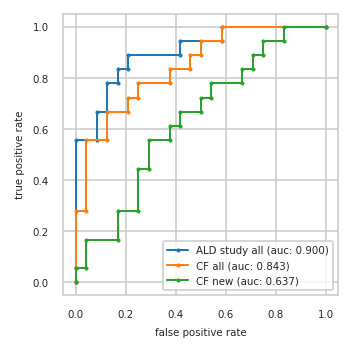

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.556  0.000 0.278  0.042 0.056
3          0.083 0.556  0.042 0.278  0.042 0.167
4          0.083 0.667  0.042 0.556  0.167 0.167
5          0.125 0.667  0.125 0.556  0.167 0.278
6          0.125 0.778  0.125 0.667  0.250 0.278
7          0.167 0.778  0.208 0.667  0.250 0.444
8          0.167 0.833  0.208 0.722  0.292 0.444
9          0.208 0.833  0.250 0.722  0.292 0.556
10         0.208 0.889  0.250 0.778  0.375 0.556
11         0.417 0.889  0.375 0.778  0.375 0.611
12         0.417 0.944  0.375 0.833  0.417 0.611
13         0.583 0.944  0.458 0.833  0.417 0.667
14         0.583 1.000  0.458 0.889  0.500 0.667
15         1.000 1.000  0.500 0.889  0.500 0.722
16           NaN   NaN  0.500 0.944  0.542 0.722
17           NaN   NaN  0.583 0.944  0.542 0.778
18           NaN   NaN  0.583 1.000  0.667 0.778
19           NaN   NaN  1.000 1.000  0.667 0.833
20           NaN   NaN    NaN   NaN  0.708 0.833
21           NaN   NaN    NaN   NaN  0.708 0.889
22           NaN   NaN    NaN   NaN  0.750 0.889
23           NaN   NaN    NaN   NaN  0.750 0.944
24           NaN   NaN    NaN   NaN  0.833 0.944
25           NaN   NaN    NaN   NaN  0.833 1.000
26           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P31946;P31946-2,M0R132;O43240,Q8TEA8
2,Q9BRA2,P10643,P51674;P51674-2;P51674-3
3,Q9UM22,Q9Y2T3;Q9Y2T3-3,A0A075B7B8
4,P61981,C9JIZ6;P07602;P07602-2;P07602-3,P04040
5,C9JF17;P05090,P61981,J3KSJ8;Q9UD71;Q9UD71-2
6,P04075,P04075,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
7,P14174,P14174,P31321
8,None,Q14894,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


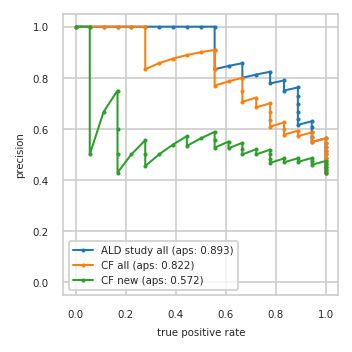

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.548 0.944     0.548 0.944     0.484 0.833
12         0.567 0.944     0.567 0.944     0.467 0.778
13         0.586 0.944     0.586 0.944     0.483 0.778
14         0.607 0.944     0.571 0.889     0.500 0.778
15         0.630 0.944     0.593 0.889     0.519 0.778
16         0.615 0.889     0.577 0.833     0.500 0.722
17         0.640 0.889     0.600 0.833     0.520 0.722
18         0.667 0.889     0.625 0.833     0.500 0.667
19         0.696 0.889     0.609 0.778     0.522 0.667
20         0.727 0.889     0.636 0.778     0.545 0.667
21         0.762 0.889     0.667 0.778     0.524 0.611
22         0.750 0.833     0.700 0.778     0.550 0.611
23         0.789 0.833     0.684 0.722     0.526 0.556
24         0.778 0.778     0.722 0.722     0.556 0.556
25         0.824 0.778     0.706 0.667     0.588 0.556
26         0.812 0.722     0.750 0.667     0.562 0.500
27         0.800 0.667     0.800 0.667     0.533 0.444
28         0.857 0.667     0.786 0.611     0.571 0.444
29         0.846 0.611     0.769 0.556     0.538 0.389
30         0.833 0.556     0.833 0.556     0.500 0.333
31         0.909 0.556     0.909 0.556     0.455 0.278
32         1.000 0.556     0.900 0.500     0.500 0.278
33         1.000 0.500     0.889 0.444     0.556 0.278
34         1.000 0.444     0.875 0.389     0.500 0.222
35         1.000 0.389     0.857 0.333     0.429 0.167
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


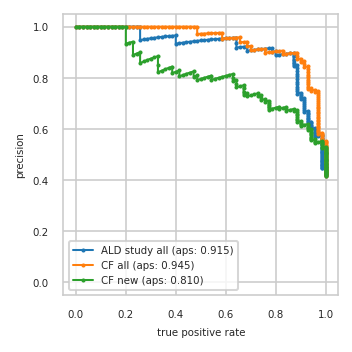

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


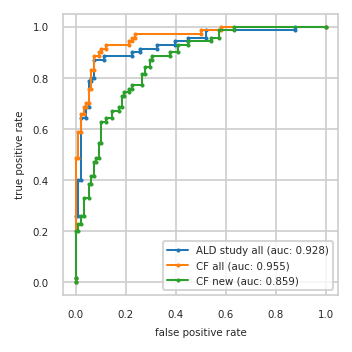

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}